## Maps

In [1]:
from pandas import read_csv
from pandas import read_excel
import numpy as np
import sklearn.manifold as manifold

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [3]:
from geopy.geocoders import Nominatim
import pickle

## Load mutual driving distances from file, available on http://www.mileage-charts.com/chart.php?p=index&a=NA&b=US&c=CA

## To load from pkl instead, skip down to 'LOAD'

In [3]:
w = read_excel('CA.xlsx')

In [4]:
km_matrix = w.as_matrix()

In [6]:
km = km_matrix[:,1:]

In [7]:
names = km_matrix[:,0]

## Get geo locations based on city names from geopy

In [14]:
geolocator = Nominatim()

In [ ]:
locations = {}

In [1]:
number_tries = 3 ## number of times to try again if it fails, e.g. times out

In [ ]:
for name in names:
    try:
        locations[name] = geolocator.geocode(name + ", CA")
    except: ## Sometimes it times out, skip those
        pass

In [67]:
for t in range(number_tries):
    for name in set(names).difference(set(locations.keys())):
        try:
            locations[name] = geolocator.geocode(name + ", CA")
        except:
            pass

In [116]:
locations = {name:lat_long[1] for name,lat_long in zip(locations.keys(),locations.values())}

In [9]:
for i in range(km.shape[0]):
    km[i,i] = 0.

# SAVE

In [79]:
pickle.dump(km,open("driving_distances.pkl", "wb"))

In [80]:
pickle.dump(names,open('names.pkl','wb'))

In [117]:
pickle.dump( locations, open( "locations.pkl", "wb" ), )

# LOAD

In [4]:
names = pickle.load( open( 'names.pkl', "rb" ) )

In [5]:
locations = pickle.load( open( 'locations.pkl', "rb" ) )

In [6]:
km = pickle.load( open( "driving_distances.pkl", "rb" ) )

## Get reduced coordinates using ISOMAP

In [7]:
Y_km = manifold.Isomap(500, 2).fit_transform(km)

/Users/gil/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/gil/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


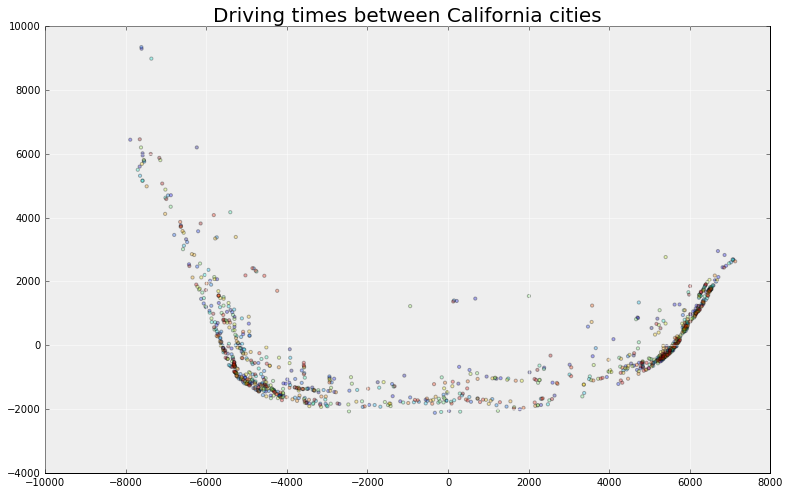

In [8]:
## Interactive map based on http://mpld3.github.io/examples/scatter_tooltip.html

fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize = (13,8))
N = 1000

scatter = ax.scatter(Y_km[:,0],
                     Y_km[:,1],
                     c=np.arange(N),
                     s=[10]*N,
                     alpha=0.3,
                     cmap=plt.cm.jet,
                    )
ax.grid(color='white', linestyle='solid')

ax.set_title("Driving times between California cities", size=20)

labels = names.tolist()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

# mpld3.show()

## Compute geodesic distances

In [9]:
## change units to rads...
locations_rads = {name:(v[0] / (180./np.pi),v[1] / (180./np.pi)) for name,v in locations.items() }

In [10]:
def dist(phi1,lambda1,phi2,lambda2):
    a = np.sin((phi1-phi2)/2.)**2 + np.cos(phi1) * np.cos(phi2) *np.sin((lambda1-lambda2)/2.)**2
    return 2.* np.arctan2(np.sqrt(a), np.sqrt(1-a) ) * 6371.

def dist_locations(loc1,loc2,locations):
    phi1,lambda1 = locations[loc1]
    phi2,lambda2 = locations[loc2]
    return dist(phi1,lambda1,phi2,lambda2)

In [11]:
dists = np.zeros((1000,1000))
for i in range(1000):
    for j in range(1000):
        dists[i,j] = dist_locations(names[i],names[j],locations_rads)

## Filter out outliers

In [12]:
L = sorted([(name,dist_total) for name, dist_total in zip(names,np.sum(dists,axis =1))], key = lambda z: float(z[1]))

In [13]:
IQR = float(L[int(len(L)*0.75)][1]) - float(L[int(len(L)*0.25)][1])

In [14]:
med = float(L[int(len(L)*0.5)][1])

In [15]:
cutoff_dist_total = IQR*10 + med

In [16]:
filtered_names = [el[0] for el in L  if float(el[1]) < cutoff_dist_total ]

In [17]:
len(filtered_names)

973

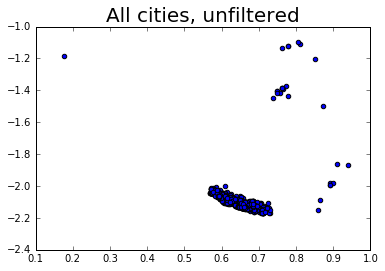

In [18]:
plt.scatter(*np.asarray([list(coord) for coord in locations_rads.values()]).T);
plt.title("All cities, unfiltered",fontsize = 20)

In [19]:
filtered_locations_rads = {name:coords for name,coords in locations_rads.items() if name in filtered_names}

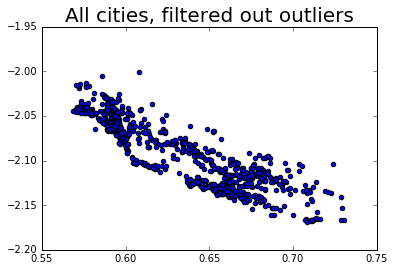

In [20]:
plt.scatter(*np.asarray([list(coord) for coord in filtered_locations_rads.values()]).T);
plt.title("All cities, filtered out outliers",fontsize = 20)

In [21]:
filtered_names = sorted(filtered_names)
num_filtered = len(filtered_names)

In [22]:
len(filtered_names)

973

In [23]:
len(filtered_locations_rads)

959

In [24]:
filtered_dists = np.zeros((num_filtered,num_filtered))
for i,name_i in enumerate(filtered_names):
    for j,name_j in enumerate(filtered_names):
        filtered_dists[i,j] = dist_locations(name_i,name_j,filtered_locations_rads)

In [32]:
Y_earth_geodesics = manifold.LocallyLinearEmbedding(500, 2,method='hessian').fit_transform(filtered_dists)

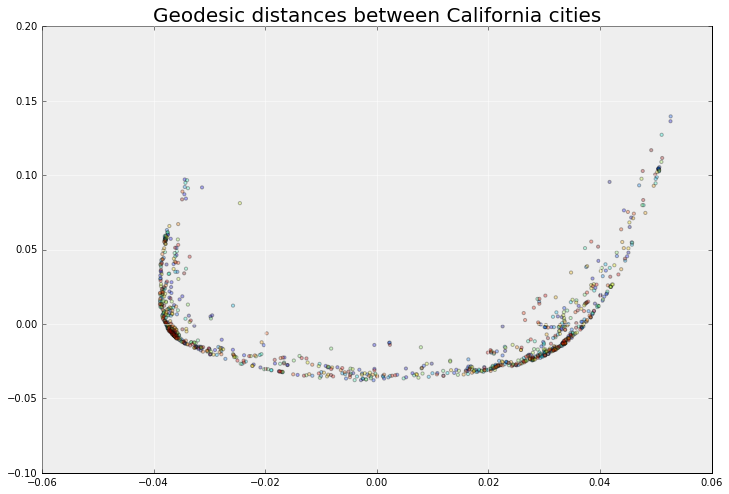

In [33]:
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize = (12,8))
N = len(filtered_names)

scatter = ax.scatter(Y_earth_geodesics[:,0],
                     Y_earth_geodesics[:,1],
                     c=np.arange(N),
                     s=[10]*N,
                     alpha=0.3,
                     cmap=plt.cm.jet,
                    )
ax.grid(color='white', linestyle='solid')

ax.set_title("Geodesic distances between California cities", size=20)

labels = names.tolist()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

# mpld3.show()